### 07 Explainability: Grad-CAM Visualization

**Goal:**  
Use Grad-CAM to visualize which regions of chest X-ray images influence model predictions, increasing trust and interpretability.

- Input: Trained Keras models (e.g., DenseNet, ResNet, Custom CNN)
- Output: Heatmaps overlayed on original X-rays


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import cv2
import os

# For directory/file paths
IMG_SIZE = (224, 224)
CLASSES = ['NORMAL', 'PNEUMONIA']

# Helper to load and preprocess an image for RGB models (transfer learning)
def load_img_for_model(img_path, preprocess_func=None, color_mode='rgb'):
    img = image.load_img(img_path, target_size=IMG_SIZE, color_mode=color_mode)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    if preprocess_func:
        img_arr = preprocess_func(img_arr)
    else:
        img_arr /= 255.0
    return img_arr


In [9]:
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap  # No .numpy() needed!


In [10]:
# Choose a model to visualize (DenseNet, ResNet, EfficientNet, CustomCNN, etc.)
model_name = "densenet121_best.h5"   # or "custom_cnn_pneumonia.h5", etc.
model_path = os.path.join('models/saved', model_name)

# Load model
model = load_model(model_path)

# Last conv layer names for common models:
# DenseNet121: 'conv5_block16_2_conv'
# ResNet50: 'conv5_block3_out'
# EfficientNetB0: 'top_conv'
# Custom CNN (if you built as above): last Conv2D layer name, e.g., 'conv2d_2'
last_conv_layers = {
    "densenet121_best.h5": 'conv5_block16_2_conv',
    "resnet50_best.h5": 'conv5_block3_out',
    "efficientnetb0_best.h5": 'top_conv',
    "vgg16_best.h5": 'block5_conv3',
    "custom_cnn_pneumonia.h5": [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
}
last_conv_layer_name = last_conv_layers[model_name]

# For transfer learning models use correct preprocessing function
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

preprocess_funcs = {
    "densenet121_best.h5": densenet_preprocess,
    "resnet50_best.h5": resnet_preprocess,
    "efficientnetb0_best.h5": efficientnet_preprocess,
    "vgg16_best.h5": vgg_preprocess,
    "custom_cnn_pneumonia.h5": None  # Just normalize to 0-1
}
preprocess_func = preprocess_funcs[model_name]
color_mode = 'rgb' if preprocess_func else 'grayscale'


In [11]:
# Directory with sample images (e.g., some test images)
test_normal_dir = os.path.join('../chest_xray', 'test', 'NORMAL')
test_pneumonia_dir = os.path.join('../chest_xray', 'test', 'PNEUMONIA')

# Pick a few images from each class
normal_imgs = [os.path.join(test_normal_dir, f) for f in os.listdir(test_normal_dir)][:3]
pneumonia_imgs = [os.path.join(test_pneumonia_dir, f) for f in os.listdir(test_pneumonia_dir)][:3]
all_imgs = normal_imgs + pneumonia_imgs


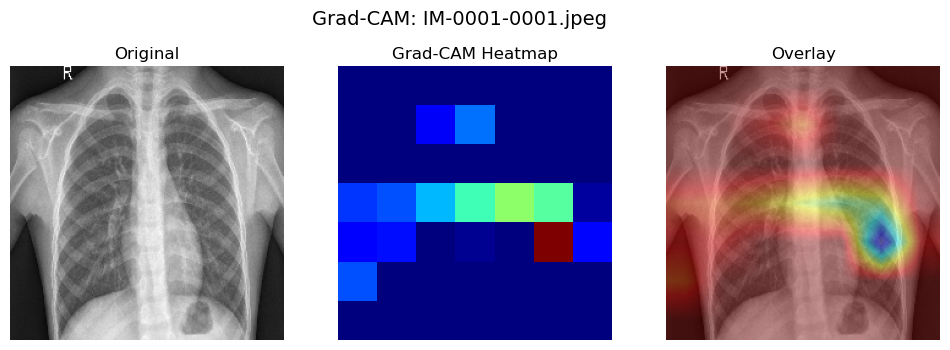

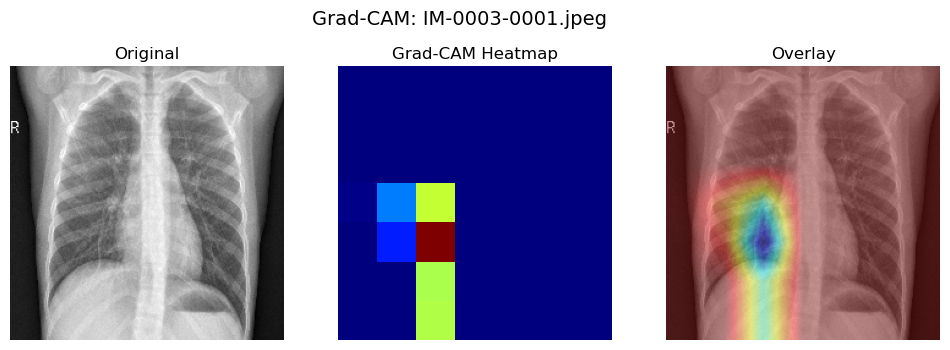

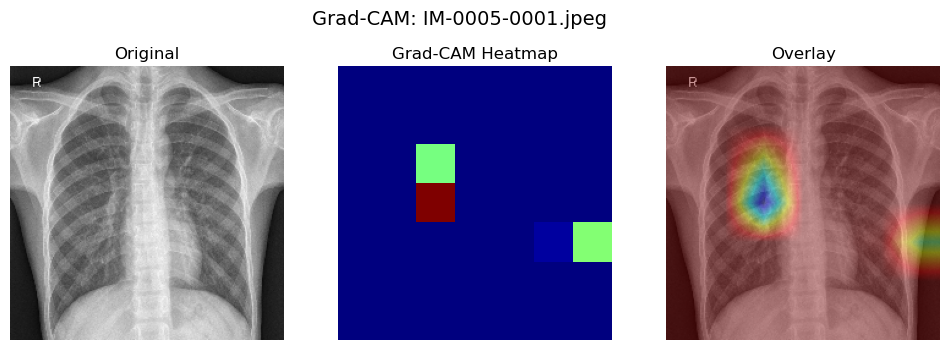

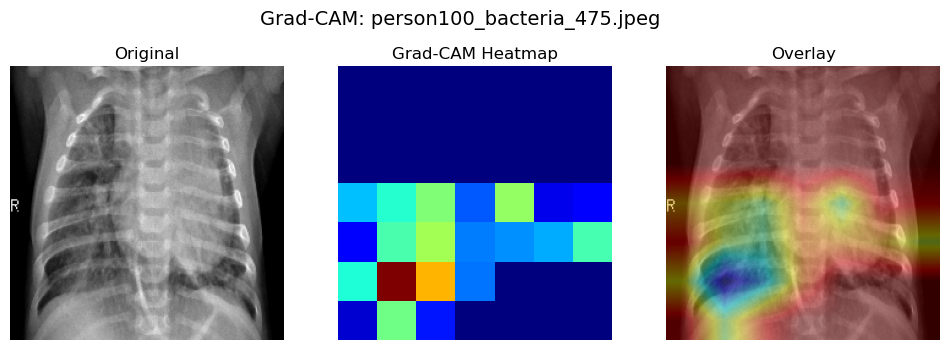

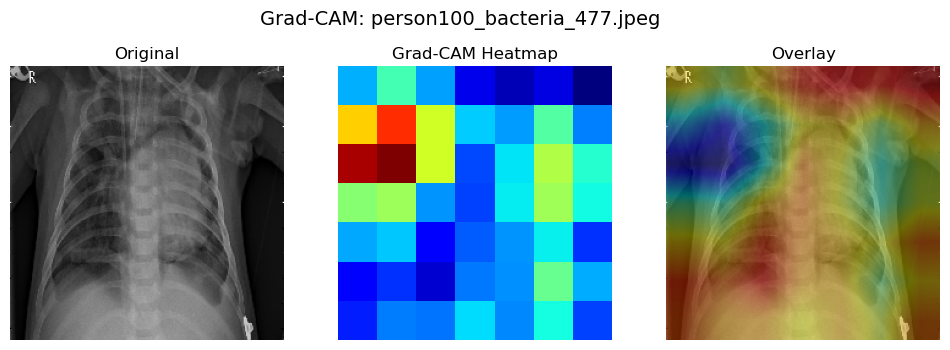

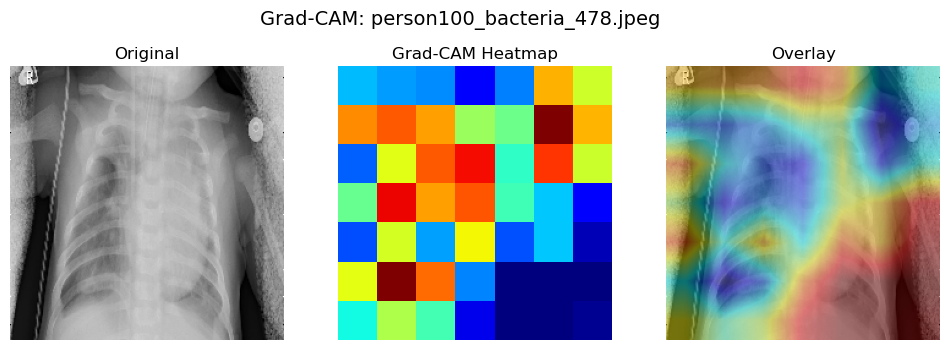

In [12]:
for img_path in all_imgs:
    # Load image for the model
    img_arr = load_img_for_model(img_path, preprocess_func, color_mode=color_mode)
    # Generate heatmap
    heatmap = make_gradcam_heatmap(model, img_arr, last_conv_layer_name)
    # Load original image for display (grayscale)
    disp_img = image.load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
    disp_img = image.img_to_array(disp_img).astype('uint8').squeeze()
    # Rescale heatmap to image size
    heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    # Overlay
    overlay = cv2.addWeighted(cv2.cvtColor(disp_img, cv2.COLOR_GRAY2BGR), 0.6, heatmap_color, 0.4, 0)
    # Plot
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(disp_img, cmap='gray')
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')
    plt.suptitle(f"Grad-CAM: {os.path.basename(img_path)}", fontsize=14)
    plt.show()
